In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class RuleBasedSystem(object):
    class Rule(object):
        def __init__(self, c, sigma_e_2, dim_ind, delta_c, salience):
            self.c = c  # decision criterion
            self.sigma_e_2 = sigma_e_2  # variance of the noise added during making a decision
            self.dim_ind = dim_ind  # the index of the dimenstion this rule is concerned with
            self.delta_c = delta_c  # for updating the criterion
            self.salience = salience  # current salience
        
        def get_discriminant_value(self, x):
            """
            Page 68, Eq. (1)
            h_E(x) = x_i - C_i
            """
            return x[self.dim_ind] - self.c
        
        def make_decision (self, x):
            """
            The decision is "B" if the discriminant value is larger than random noise and "A" otherwise.
            Page 68:
            
            "Respond A on trial n if h_E(x) < ε; respond B if h_E(x) > ε"
            
            There are only strict inequalities here. The probability of equality is near zero but it still
            cleaner to stick equality somewhere.
            
            Note: For some reason, larger values on any dimension are associated with a higher probabilty of
            selecting "B".
            """
            h_E = self.get_discriminant_value(x)  # h_E(x)
            epsilon = np.random.normal(scale = np.sqrt(self.sigma_e_2))
            if h_E > epsilon:
                return "B"
            elif h_E <= epsilon:  
                return "A"
            
        def update_salience(self, delta):
            """
            Change salience by delta
            """
            self.salience += delta 
            self.salience = max(0, self.salience)  # to avoid negative salience values
            
        def update(self, x, feedback):
            """
            We could not understand from the book whether we should compare the discriminant value to the noise
            during the criterion update. For now we decided that using noise here does not make much sense.
            """
            
            # Determine what decision we would lean towards if there was no noise
            h_E = self.get_discriminant_value(x)
            if h_E > 0:
                deterministic_decision = 'B'
            elif h_E <= 0:
                deterministic_decision = 'A'
            
            # Larger c => greater chance of selecting 'A'
            # We update the criterion only if there is a mistake. The change is constnant for a given rule - self.delta_c
            if deterministic_decision == 'B' and feedback == 'A':
                self.c += self.delta_c
            elif deterministic_decision == 'A' and feedback == 'B':
                self.c -= self.delta_c
                
        def __str__(self):
            return 'One-dimensional rule on dimension {} with C={}'.format(
                self.dim_ind, self.c)
                
            
    def __init__(self, n_dims, sigma_e_2, gamma, lambda_, delta_C, delta_E, delta_criterion):
        
        self.n_dims = n_dims  # number of dimensions (r) 
        self.sigma_e_2 =  sigma_e_2  # variance of the noise added during making a decision by each rule
        self.gamma = gamma  # perceverance, lower=easier_switch
        self.lambda_ = lambda_  #selection_param, =mu for Poisson for X, 
                                # higher lambdo=higher prob in n+1
        # These values are used to update the salience of the selected rule
        self.delta_C = delta_C  # in case the decision was correct
        self.delta_E = delta_E  # in case the decision led to an error
        
        # This value is used to update rules' criteria
        self.delta_criterion = delta_criterion
        
        c_init = 0.5  # unless the de
        salience_init = 1.0 / n_dims
        
        self.rules = [self.Rule(c=c_init, 
                                sigma_e_2=sigma_e_2, 
                                dim_ind=dim_ind, 
                                delta_c=delta_criterion, 
                                salience=salience_init) 
                      for dim_ind in range(n_dims)]
        
        # During each iteration two rules get temporary salience bumps - the last one used and a random one.
        # Since 'the last one used' does not make sense on the first iteration, let's just pick one at random.
        self.current_rule = np.random.choice(self.rules, 1)[0]
        
    def process_stimulus(self, x):
        self.current_rule = self._select_rule()
        self.last_stimulus = x
        self.current_prediction = self.current_rule.make_decision(x) #curent response
        
    def _select_rule(self):
        saliences = [rule.salience for rule in self.rules]
        
        # Perseveration, Y_i(n) = Z_i(n) + gamma, p. 69, Eq. (4)
        current_rule_ind = self.rules.index(self.current_rule)
        saliences[current_rule_ind] += self.gamma
        
        # Select a random rule, Rj
        n_rules = len(self.rules)
        indices = list(range(n_rules))
        indices.remove(current_rule_ind) #remove Ri
        random_rule_ind = np.random.choice(indices, 1)[0] #select Rj
        
        # Add X to the random rule's salience, Y_j(n)=Z_j(n) + X, p. 70, Eq. (5)
        X = np.random.poisson(lam=self.lambda_)
        saliences[random_rule_ind] += X
        
        # Select a rule randomly, p(Rk)=Yk(n)/sum(Ysal(n)) sum_sal: 1 to m, p. 70, Eq. (7)
        pties = [salience / sum(saliences) for salience in saliences]
        return np.random.choice(self.rules, size=1, p=pties)[0]
        
    def process_feedback(self, feedback):
        is_correct = self.current_prediction == feedback
        self._update_saliences(feedback)
        self._update_rules(feedback)
        
        return is_correct
    
    def _update_saliences(self, feedback):
        # The salience is updated only for the selected rule. Depending on the success of the prediction,
        # it is changed by one of the two constants. P. 69, Eqs. (2), (3)
        if self.current_prediction == feedback:
            delta = self.delta_C
        else:
            delta = -self.delta_E
        self.current_rule.update_salience(delta=delta)
        
    def _update_rules(self, feedback):
        x = self.last_stimulus
        for rule in self.rules:
            rule.update(x, feedback)

In [3]:
rbs = RuleBasedSystem(n_dims=4, sigma_e_2=0.0, gamma=1.0, lambda_=5.0, delta_C=0.0025, 
                      delta_E=0.02, delta_criterion=0.05)

In [4]:
from itertools import product
stimuli = list(product((0, 1), repeat=4))

rb_categs = ["B" if stim[0] == 1 else "A" for stim in stimuli]

for stimulus, category in zip(stimuli, rb_categs):
    print(stimulus, category)

(0, 0, 0, 0) A
(0, 0, 0, 1) A
(0, 0, 1, 0) A
(0, 0, 1, 1) A
(0, 1, 0, 0) A
(0, 1, 0, 1) A
(0, 1, 1, 0) A
(0, 1, 1, 1) A
(1, 0, 0, 0) B
(1, 0, 0, 1) B
(1, 0, 1, 0) B
(1, 0, 1, 1) B
(1, 1, 0, 0) B
(1, 1, 0, 1) B
(1, 1, 1, 0) B
(1, 1, 1, 1) B


In [5]:
np.random.seed(5678590)

results = list()

def present_the_stimuli():
    for _ in range(500):
        stimulus_ind = np.random.randint(8)
        stimulus = stimuli[stimulus_ind]
        feedback = rb_categs[stimulus_ind]
        rbs.process_stimulus(stimulus)
        results.append(rbs.process_feedback(feedback))
        
present_the_stimuli()

In [6]:
[rule.c for rule in rbs.rules]

[0.5, 1.0000000000000004, 1.0000000000000004, 1.0000000000000004]

The onle relevant rule - rule 1 - did not change its criterion. This makes sense because without noise it is always correct.

Criteria of all the other rules went just above $1$ which makes the discriminant value less than $0$ for all the sitmuli. Since we have zero noise it means these rules always choose category "A". This makes no sense since for any criterion the chances of an irrelevant rule to be correct are always 50/50. There should not be a bias towards category "A".

In [7]:
[rule.salience for rule in rbs.rules]

[0.5799999999999985,
 0.4975000000000003,
 0.4600000000000003,
 0.5324999999999995]

These saliences don't makes sense at the first glance. One would expect the salience of the first rule to be large while the others should have plummeted. Maybe the reason this is not so is that the irrelevant rules are rarely chosen and thus their salience do not get updated much. Let's see if presenting the stimuli again would only lead to the changes in the salience of the first rule.

In [8]:
present_the_stimuli()
[rule.salience for rule in rbs.rules]

[0.9499999999999906, 0.8124999999999936, 0.749999999999995, 0.8074999999999937]

No, this is something else. The other rules do get selected and they are correct more often than not (the penalty for an error is larger than the increase in salience when the prediciton is correct, delta_E > delta_C). At the second glance, this does not make sense either.

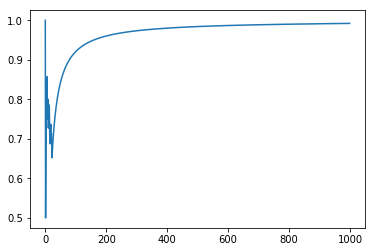

In [9]:
plt.plot(np.cumsum(results) / (np.arange(len(results)) + 1))